In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as geek
from scipy import signal
from scipy.signal import butter, filtfilt, medfilt, find_peaks, wiener
from pywt import wavedec
import pywt
import math
import scipy.integrate as integrate
from pylab import figure, clf, plot, xlabel, ylabel, title, grid, axes, show
from scipy.signal import find_peaks
import statsmodels.api as sm
import scipy.fftpack
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

# **Preprocessing**

In [2]:
sunject_0 = pd.read_csv('/content/drive/MyDrive/ECG_redings/patient18.csv')
ecgX = sunject_0['sample interval'].tolist()
ecgY = sunject_0['v3'].tolist()
ecgX = ecgX[:60000]
ecgY = ecgY[:60000]

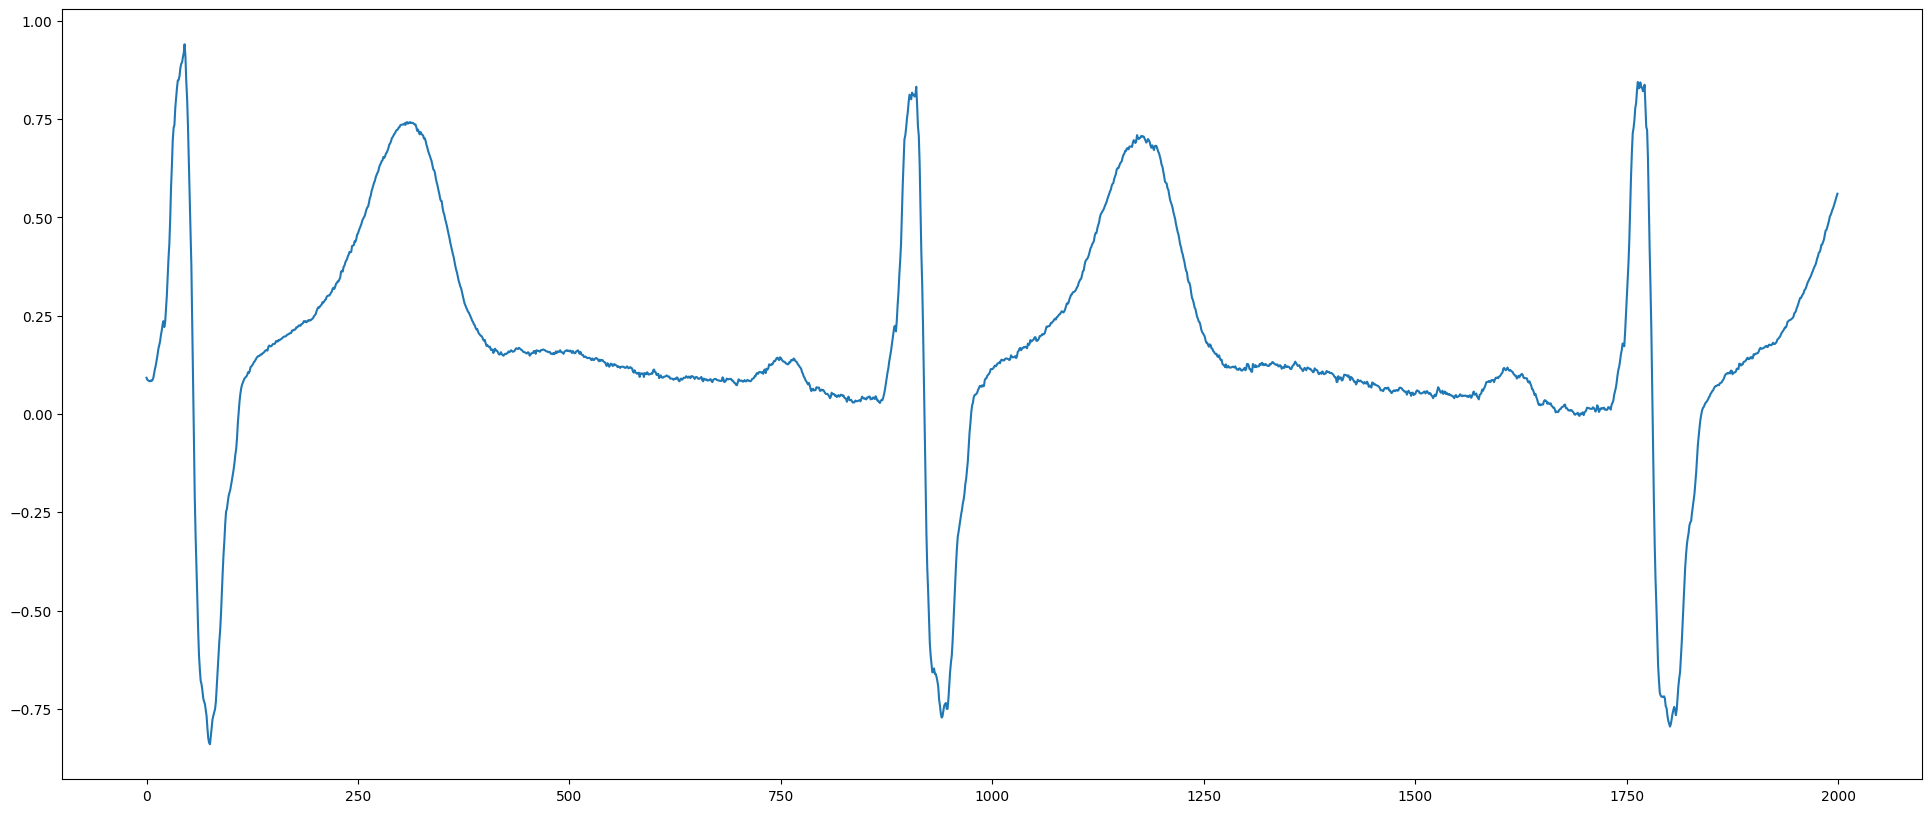

In [4]:
plt.figure(figsize=(24, 10))
plt.plot(ecgX[:2000], ecgY[:2000])
plt.show()

## **Removing baseline-wander and denoise the signal**

In [5]:
def baseline_denoise_removal(signal_data):

  def remove_baseline_wander(signal, Low_Cutoff=1,High_Cutoff=40, sampling_freq=1000, order = 2):
    nyq = 0.5 * sampling_freq
    low = Low_Cutoff / nyq
    high = High_Cutoff / nyq
    b, a = butter(order, [low, high], btype='band', analog=False, fs=None)
    Filtered_Data = filtfilt(b, a, signal)
    return Filtered_Data


  def normalize_signal(signal):
      return (signal - np.mean(signal)) / np.std(signal)

  def denoise_signal(signal_data, window_length=51, polyorder=3):
      # Apply Savitzky-Golay filter for denoising
      return signal.savgol_filter(signal_data, window_length=window_length, polyorder=polyorder)

  signal_data = remove_baseline_wander(signal_data)
  signal_data = normalize_signal(signal_data)
  signal_data = denoise_signal(signal_data)

  return signal_data


In [6]:
filterd_signal_2  = baseline_denoise_removal(ecgY)

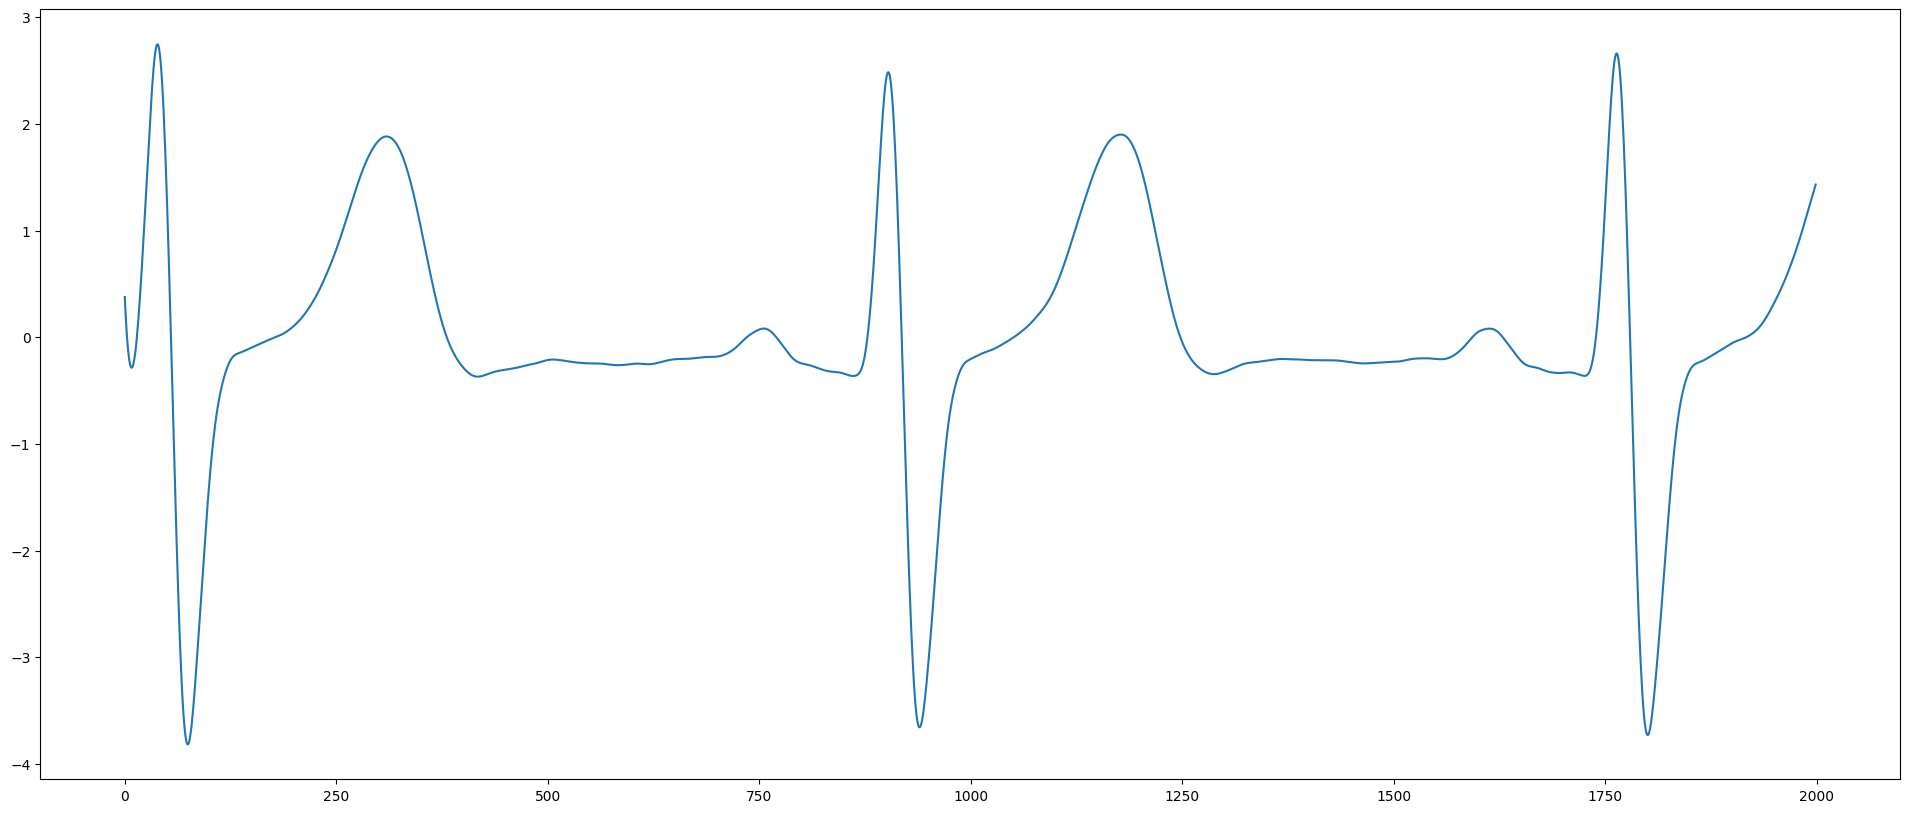

In [7]:
plt.figure(figsize=(24, 10))
plt.plot(np.arange(0, len(filterd_signal_2[:2000])), filterd_signal_2[:2000])
plt.show()

- The first approach is used to filter the signal

# **Signal Segmentation**

## 1. **Finding R peaks to segemnt the signal by complex heartbeats**

In [10]:
def find_R_peaks(filtered_signal, sampling_rate=1000):
    # Find R peaks in the filtered signal
    peaks, _ = find_peaks(filtered_signal, height=0)
    max_peak_value = np.max(filtered_signal[peaks])
    # print(max_peak_value)
    r_threshold = max_peak_value - ( max_peak_value * 0.2 )
    # print(r_threshold)
    R_indices = []
    amp = []
    for i in range(len(peaks) - 1):
        p = peaks[i]
        if filtered_signal[p] > r_threshold:
            R_indices.append(peaks[i])
            amp.append(filtered_signal[p])

    return R_indices, amp

R_indices, y = find_R_peaks(filterd_signal_2)

70
[39, 903, 1764, 2636, 3509, 4369, 5219, 6075, 6921, 7760, 8587, 9404, 10225, 11056, 11902, 12746, 13579, 14431, 15286, 16134, 16973, 17828, 18681, 19525, 20367, 21225, 22094, 22960, 23823, 24699, 25574, 26440, 27311, 28185, 29061, 29917, 30777, 31642, 32499, 33357, 34223, 35083, 35932, 36793, 37661, 38525, 39387, 40264, 41153, 42033, 42926, 43817, 44703, 45569, 46437, 47318, 48205, 49087, 49971, 50865, 51750, 52623, 53499, 54376, 55238, 56108, 56991, 57861, 58712, 59564]


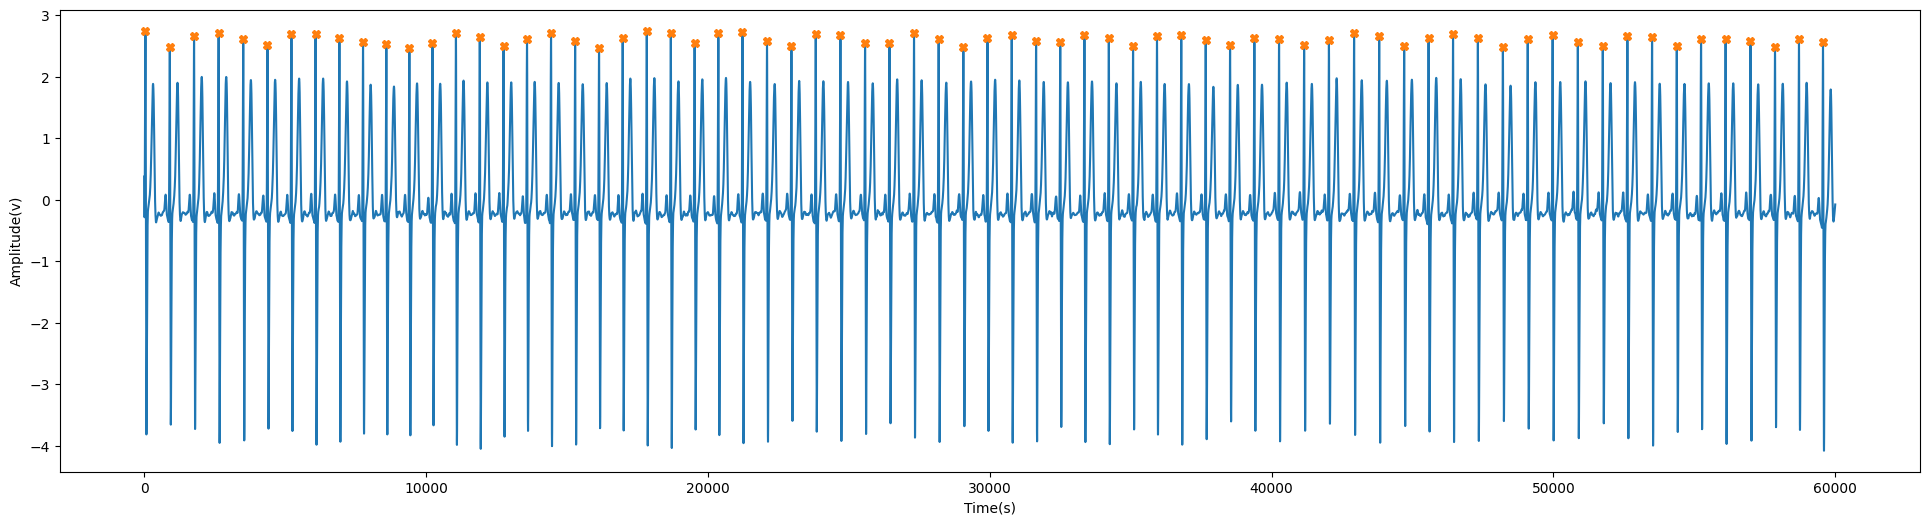

In [11]:
print(len(R_indices))
print(R_indices)

plt.figure(figsize=(24,6))
plt.plot(np.arange(0, len(filterd_signal_2[:])), filterd_signal_2[:])
plt.xlabel("Time(s)")
plt.ylabel("Amplitude(v)")
plt.plot(R_indices[:],y[:],'X')
plt.show()

## 2. **Segemnt the signal after R intervals**

In [13]:
def dynamic_segmentation(ecg_signal, r_peaks, segment_length=2):
    segments = []
    current_segment = []

    for r_peak_index in r_peaks:
        current_segment.append(r_peak_index)

        if len(current_segment) == (segment_length + 1):
            segments.append(current_segment)
            current_segment = []

    # If there are remaining R-peaks not included in a segment
    if current_segment:
        segments.append(current_segment)

    segmented_signal = []
    for segment in segments:
        start_index = segment[0]
        end_index = segment[-1]
        segmented_signal.append(ecg_signal[start_index:end_index+1])

    if len(r_peaks) % (segment_length + 1) != 0 :
      segmented_signal = segmented_signal[:-1]

    return segmented_signal


segmented_signal = dynamic_segmentation(filterd_signal_2, R_indices)

In [14]:
print(len(segmented_signal))

23


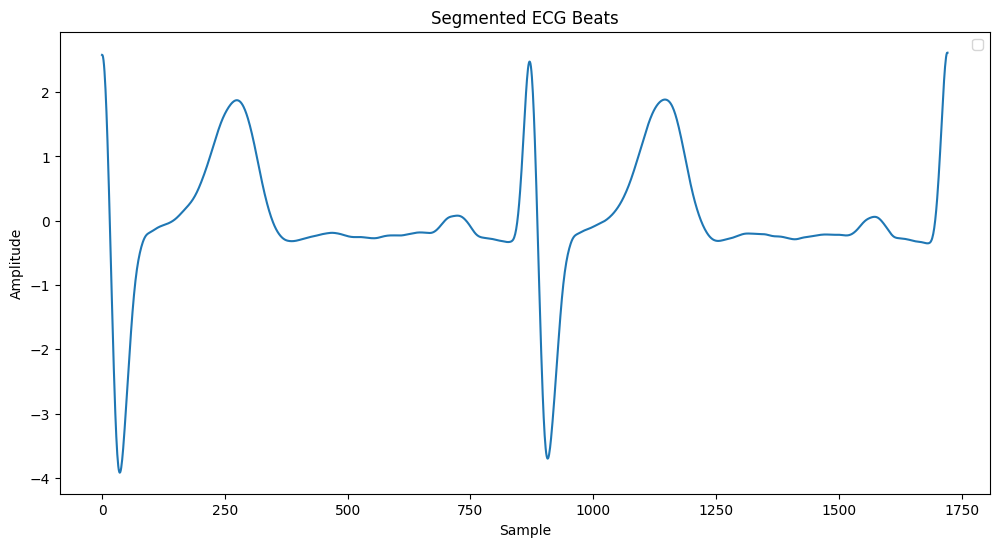

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, len(segmented_signal[22])), segmented_signal[22])
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Segmented ECG Beats')
plt.legend()
plt.show()

In [16]:
print(len(segmented_signal[1]))

1734


In [17]:
def signal_segmentation(signal_, segment_length):
  R_indices, y = find_R_peaks(signal_)
  segmented_signal = dynamic_segmentation(signal_, R_indices, segment_length)

  return segmented_signal

# **Feature extraction for each segemnt**

## **1. AC/DCT Features**

In [24]:
Acc = sm.tsa.acf(segmented_signal[0], nlags=1500)
DCT = scipy.fftpack.dct(Acc, type= 2)

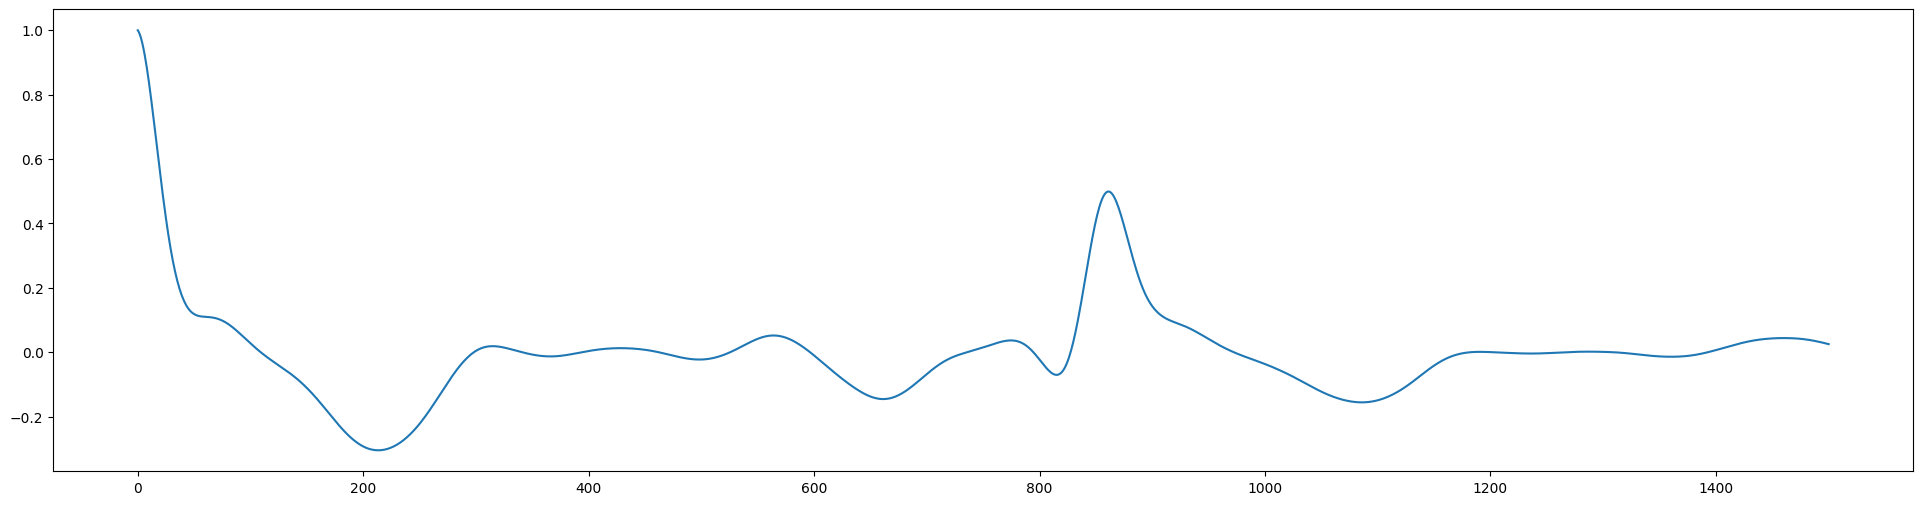

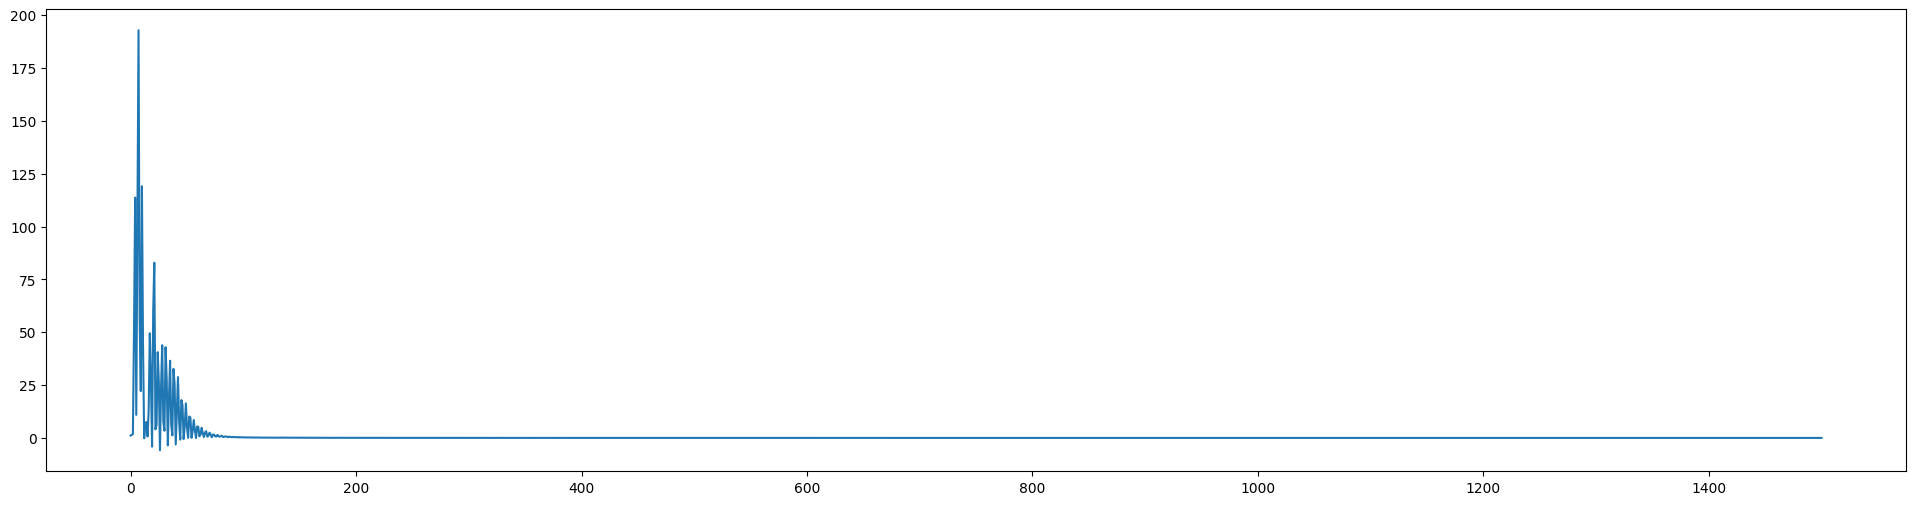

In [25]:
plt.figure(figsize=(24,6))
plt.plot(range(0, len(Acc)), Acc)
plt.show()

plt.figure(figsize=(24,6))
plt.plot(range(0, len(DCT)), DCT)
plt.show()

In [26]:
def ac_dct_features(segments):
  dct_features = []
  for seg in segments:
    Acc = sm.tsa.acf(seg, nlags=5000)
    DCT = scipy.fftpack.dct(Acc, type= 2)
    DCT = DCT[:200]
    dct_features.append(DCT)

  return dct_features

In [27]:
signal_acdct_features = ac_dct_features(segmented_signal)

23


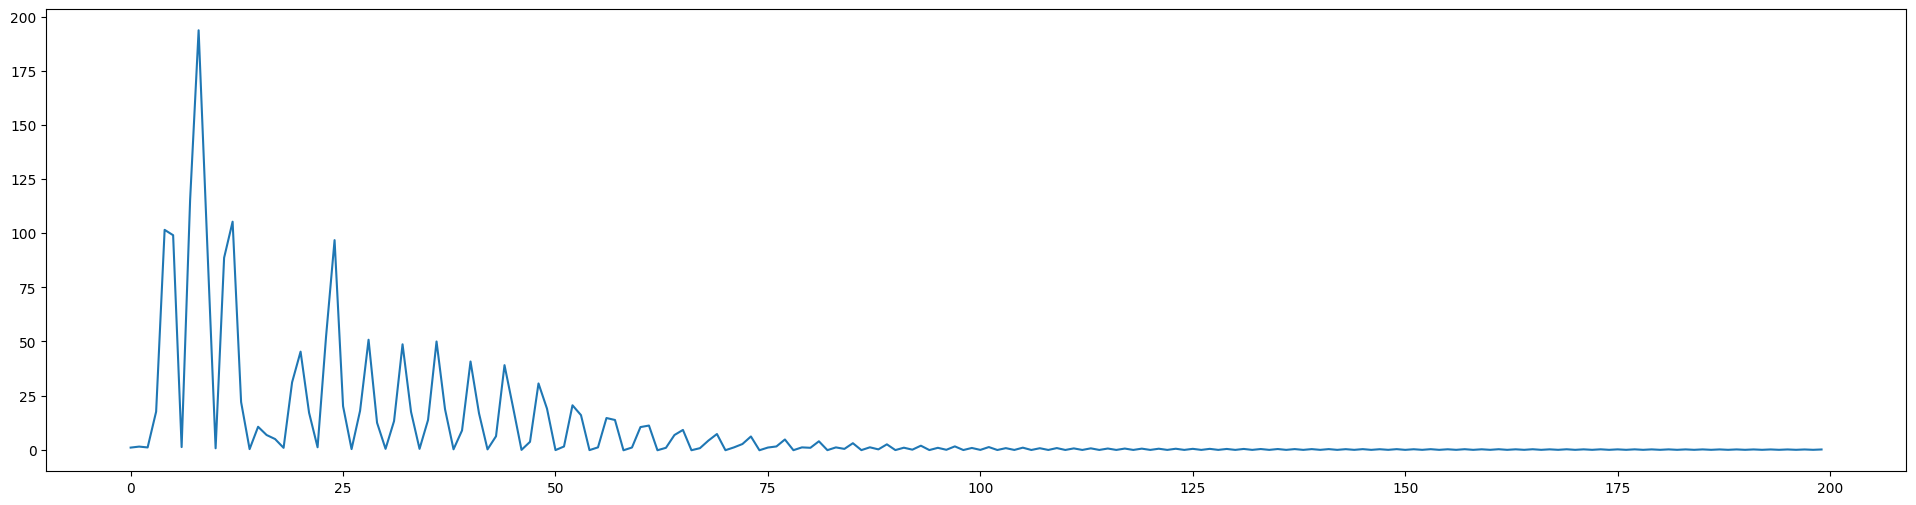

In [28]:
print(len(signal_acdct_features))
plt.figure(figsize=(24,6))
plt.plot(range(0, len(signal_acdct_features[10])), signal_acdct_features[10])
plt.show()

## **2. Wavelet Coefficients Features**

In [30]:
def extract_wavelet_coefficients(ecg_signal, sampling_rate=1000, wavelet='db4', level=5, freq_band=(1, 40)):

    nyquist_freq = sampling_rate / 2

    max_freq_band = min(nyquist_freq, freq_band[1])
    min_freq_band = max(freq_band[0], 1)
    max_level = int(np.floor(np.log2(nyquist_freq / min_freq_band))) + 1
    level = min(level, max_level)

    coeffs = pywt.wavedec(ecg_signal, wavelet, level=level)

    coeffs_band = []
    for level_coeffs in coeffs[1:]:
        level_freq = np.linspace(0, nyquist_freq, len(level_coeffs))
        indices_band = np.where((level_freq >= min_freq_band) & (level_freq <= max_freq_band))[0]
        coeffs_band.append(level_coeffs[indices_band])

    feature_vector = np.concatenate(coeffs_band).ravel()
    feature_vector = feature_vector[:20]

    return feature_vector

In [31]:
wavelet_features = extract_wavelet_coefficients(segmented_signal[0])

20


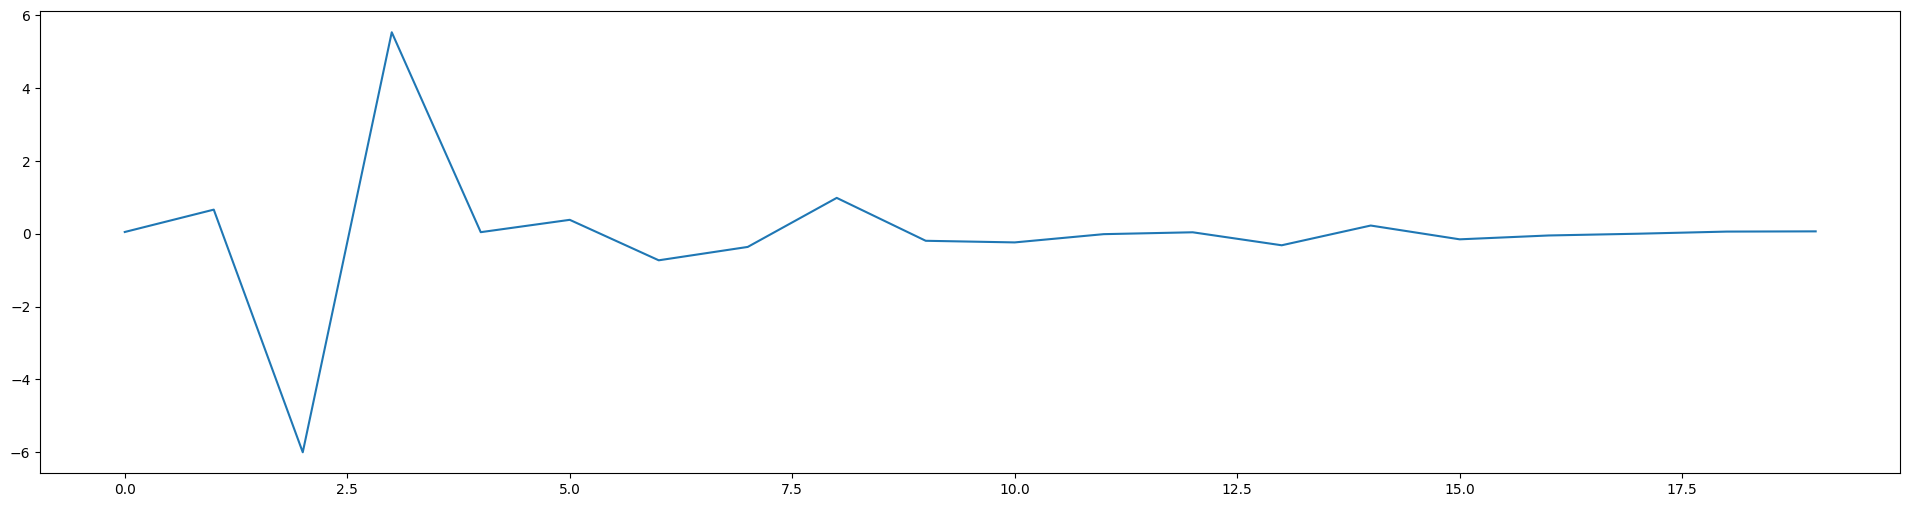

In [32]:
print(len(wavelet_features))
# print(signal_wavelet_features[60:70])
plt.figure(figsize=(24,6))
plt.plot(range(0, len(wavelet_features)), wavelet_features)
plt.show()

In [33]:
def wavelet_features(segemnts):
  wavelet_features = []
  for seg in segemnts:
    wavelet_features.append(extract_wavelet_coefficients(seg))

  return wavelet_features

signal_wavelet_features = wavelet_features(segmented_signal)

23
20


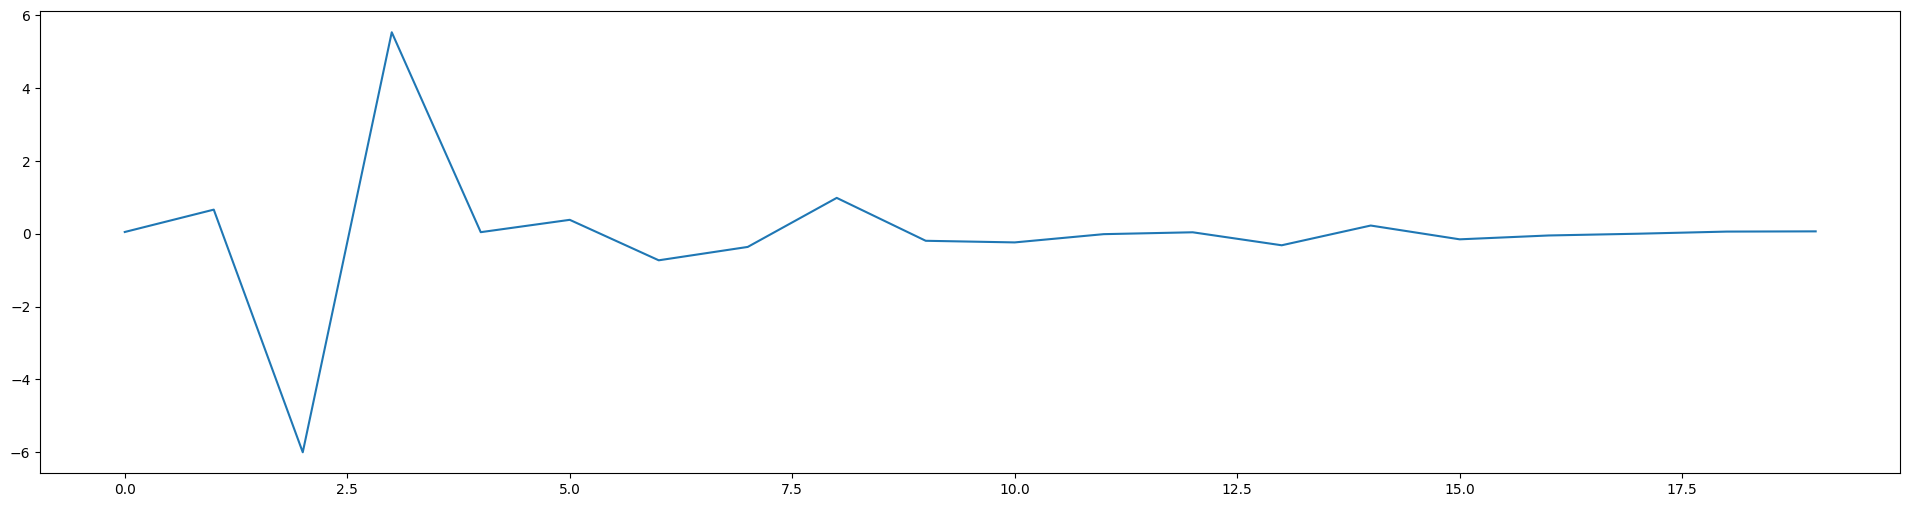

In [34]:
print(len(signal_wavelet_features))
print(len(signal_wavelet_features[0]))
plt.figure(figsize=(24,6))
plt.plot(range(0, len(signal_wavelet_features[0])), signal_wavelet_features[0])
plt.show()

In [35]:
# print(signal_acdct_features[0])
print('the signal shape is: ', '[', len(signal_acdct_features), ',', len(signal_acdct_features[0]), ']')

the signal shape is:  [ 23 , 200 ]


In [36]:
# print(signal_wavelet_features[0])
print('the signal shape is: ', '[', len(signal_wavelet_features), ',', len(signal_wavelet_features[0]), ']')

the signal shape is:  [ 23 , 20 ]


## **3. choose feature extraction techniqu**

In [37]:
def extract_features(segments_, choice='ac_dct'):
  if choice == 'ac_dct':
    features = ac_dct_features(segments_)
  if choice == 'wavelet':
    features = wavelet_features(segments_)

  return features

# **Data Preparing**

In [38]:
def preprocessing_(subject_, segments_no, choice):
  # reading channels 'electrodes'.
  ch_1 = subject_['i'].to_list()
  ch_1 = ch_1[:-100]
  ch_2 = subject_['avl'].to_list()
  ch_2 = ch_2[:-100]
  ch_3 = subject_['v3'].to_list()
  ch_3 = ch_3[:-100]
  ch_4 = subject_['v4'].to_list()
  ch_4 = ch_4[:-100]
  ch_5 = subject_['v5'].to_list()
  ch_5 = ch_5[:-100]
  ch_6 = subject_['v6'].to_list()
  ch_6 = ch_6[:-100]
  ch_7 = subject_['vx'].to_list()
  ch_7 = ch_7[:-100]

  # filtering and preprocessing using method 1
  f1_ = baseline_denoise_removal(ch_1)
  f2_ = baseline_denoise_removal(ch_2)
  f3_ = baseline_denoise_removal(ch_3)
  f4_ = baseline_denoise_removal(ch_4)
  f5_ = baseline_denoise_removal(ch_5)
  f6_ = baseline_denoise_removal(ch_6)
  f7_ = baseline_denoise_removal(ch_7)


  # Segemnt each filtered signal
  # segments_no = 3
  segs1_ = signal_segmentation(f1_, segments_no)
  segs2_ = signal_segmentation(f2_, segments_no)
  segs3_ = signal_segmentation(f3_, segments_no)
  segs4_ = signal_segmentation(f4_, segments_no)
  segs5_ = signal_segmentation(f5_, segments_no)
  segs6_ = signal_segmentation(f6_, segments_no)
  segs7_ = signal_segmentation(f7_, segments_no)

  # Extract features from each segment
  # choice = 'ac_dct'
  fet1_ = extract_features(segs1_, choice)
  fet2_ = extract_features(segs2_, choice)
  fet3_ = extract_features(segs3_, choice)
  fet4_ = extract_features(segs4_, choice)
  fet5_ = extract_features(segs5_, choice)
  fet6_ = extract_features(segs6_, choice)
  fet7_ = extract_features(segs7_, choice)


  # Make all extracted features in one array
  all_features = np.concatenate((fet1_, fet2_, fet3_, fet4_, fet5_, fet6_, fet7_))
  print('all-->', len(all_features))
  print('----------------------------')

  return all_features

In [39]:
sub0 = pd.read_csv('/content/drive/MyDrive/ECG_redings/patient17.csv')
sub1 = pd.read_csv('/content/drive/MyDrive/ECG_redings/patient18.csv')
sub2 = pd.read_csv('/content/drive/MyDrive/ECG_redings/patient21.csv')
sub3 = pd.read_csv('/content/drive/MyDrive/ECG_redings/patient23.csv')

## **1. Using AC/DCT Features**

In [40]:
subject_0 = preprocessing_(sub0, 2, 'ac_dct')
subject_1 = preprocessing_(sub1, 2, 'ac_dct')
subject_2 = preprocessing_(sub2, 2, 'ac_dct')
subject_3 = preprocessing_(sub3, 2, 'ac_dct')


print(subject_0.shape)
print(subject_1.shape)
print(subject_2.shape)
print(subject_3.shape)

all--> 123
----------------------------
all--> 133
----------------------------
all--> 179
----------------------------
all--> 124
----------------------------
(123, 200)
(133, 200)
(179, 200)
(124, 200)


In [42]:
# def dataset_train_test(sub0, sub1, sub2, sub3):
X_train = []
y_train = []
X_test = []
y_test = []

min_segs = np.min([len(subject_0), len(subject_2), len(subject_3), len(subject_3)])
sub0 = subject_0
sub1 = subject_1[:min_segs]
sub2 = subject_2[:min_segs]
sub3 = subject_3[:min_segs]

random.shuffle(sub0)
random.shuffle(sub1)
random.shuffle(sub2)
random.shuffle(sub3)


s0_train = sub0[:103]
s0_test = sub0[103:]

s1_train = sub1[:103]
s1_test = sub1[103:]

s2_train = sub2[:103]
s2_test = sub2[103:]

s3_train = sub3[:103]
s3_test = sub3[103:]

X_train = np.concatenate((s0_train, s1_train, s2_train, s3_train), axis=0)
y_train = np.concatenate((np.zeros(len(s0_train)), np.ones(len(s1_train)), 2*np.ones(len(s2_train)), 3*np.ones(len(s3_train))), axis=0)

X_test = np.concatenate((s0_test, s1_test, s2_test, s3_test), axis=0)
y_test = np.concatenate((np.zeros(len(s0_test)), np.ones(len(s1_test)), 2*np.ones(len(s2_test)), 3*np.ones(len(s3_test))), axis=0)


In [43]:
print(X_train.shape)
print(X_test.shape)


(412, 200)
(80, 200)


In [ ]:
# # take some smaples for testing the model
# s1 = s0_test[:20]
# s2 = s1_test[:5]
# print(s1.shape)
# print(s2.shape)
# test_subject = np.concatenate((s1, s2), axis=0)
# print(test_subject.shape)

(20, 200)
(5, 200)
(25, 200)


In [44]:
rand_train = np.random.permutation(len(X_train))
rand_test = np.random.permutation(len(X_test))

In [45]:
X_train = X_train[rand_train]
y_train = y_train[rand_train]

X_test = X_test[rand_test]
y_test = y_test[rand_test]

In [46]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(412, 200)
(412,)
(80, 200)
(80,)


In [47]:
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, y_train)

predictions = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("SVM Accuracy:", f"{accuracy*100} %")

SVM Accuracy: 98.75 %


In [ ]:
pickle_file = "svm_ac_dct.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(svm_classifier, file)

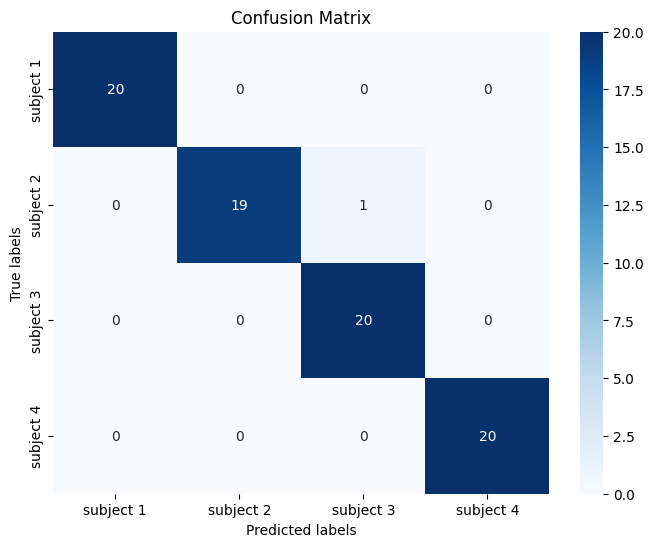

Accuracy: 0.9875
Precision: 0.9880952380952381
Recall: 0.9875
F1 Score: 0.9874921826141339


In [48]:
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['subject 1', 'subject 2', 'subject 3', 'subject 4'], yticklabels=['subject 1', 'subject 2', 'subject 3', 'subject 4'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


In [53]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

predictions = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Random Forest Accuracy:", f"{accuracy * 100} %")

Random Forest Accuracy: 97.5 %


In [ ]:
pickle_file = "rf_ac_dct.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(rf_classifier, file)

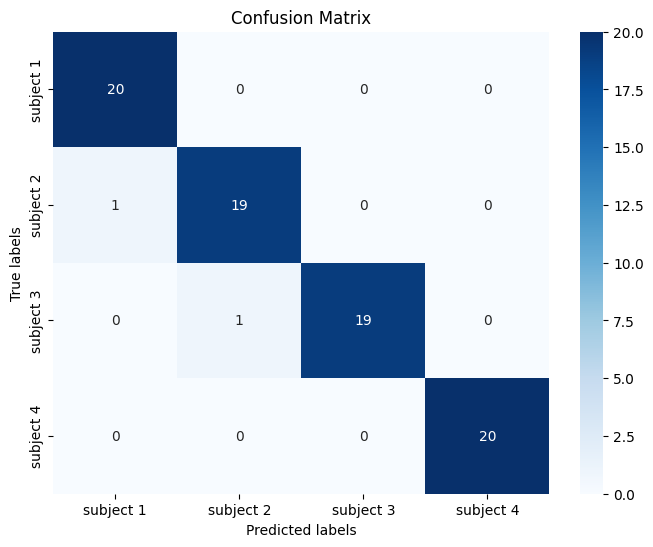

Accuracy: 0.975
Precision: 0.9755952380952381
Recall: 0.975
F1 Score: 0.9749921826141339


In [54]:
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['subject 1', 'subject 2', 'subject 3', 'subject 4'], yticklabels=['subject 1', 'subject 2', 'subject 3', 'subject 4'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [50]:
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
#     Dropout(0.5),
#     Dense(32, activation='relu'),
#     Dropout(0.5),
#     Dense(4, activation='softmax')
# ])

# # optimizer = SGD(learning_rate=0.01, momentum=0.7)
# optimizer = Adam(learning_rate=0.01)

# model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# model.summary()

# early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                12864     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 15076 (58.89 KB)
Trainable params: 15076 (58.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
11/11 [=

In [51]:
# predictions = np.argmax(model.predict(X_test), axis=-1)

3/3 [==============================] - 0s 4ms/step


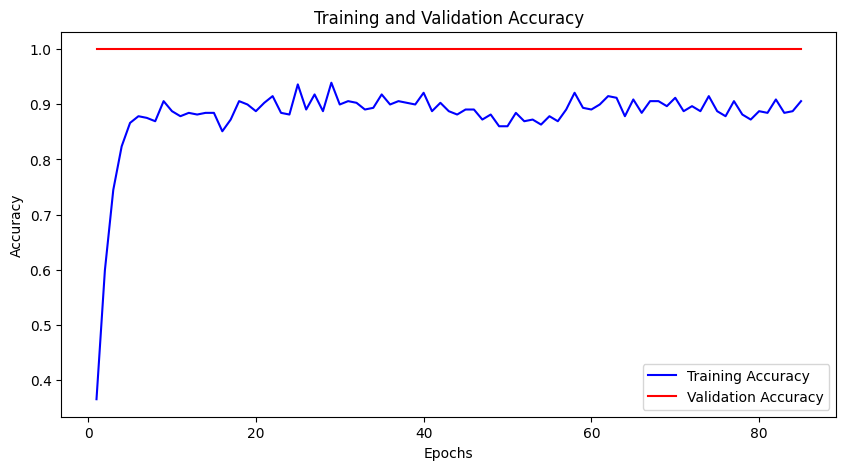

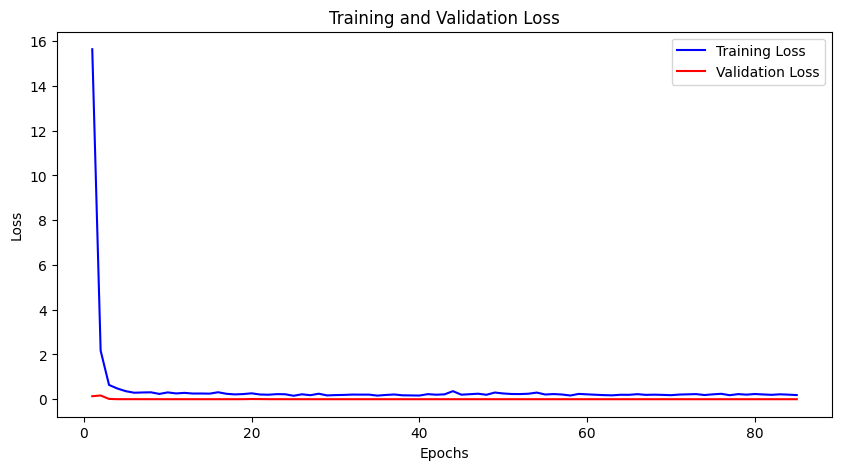

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **2. Using Wavelet Coefficients Features**

In [57]:
sub0 = pd.read_csv('/content/drive/MyDrive/ECG_redings/patient17.csv')
sub1 = pd.read_csv('/content/drive/MyDrive/ECG_redings/patient18.csv')
sub2 = pd.read_csv('/content/drive/MyDrive/ECG_redings/patient21.csv')
sub3 = pd.read_csv('/content/drive/MyDrive/ECG_redings/patient23.csv')

subject_0 = preprocessing_(sub0, 2, 'wavelet')
subject_1 = preprocessing_(sub1, 2, 'wavelet')
subject_2 = preprocessing_(sub2, 2, 'wavelet')
subject_3 = preprocessing_(sub3, 2, 'wavelet')


print(subject_0.shape)
print(subject_1.shape)
print(subject_2.shape)
print(subject_3.shape)

all--> 123
----------------------------
all--> 133
----------------------------
all--> 179
----------------------------
all--> 124
----------------------------
(123, 20)
(133, 20)
(179, 20)
(124, 20)


In [58]:
X_train = []
y_train = []
X_test = []
y_test = []

min_segs = np.min([len(subject_0), len(subject_2), len(subject_3), len(subject_3)])
sub0 = subject_0
sub1 = subject_1[:min_segs]
sub2 = subject_2[:min_segs]
sub3 = subject_3[:min_segs]

random.shuffle(sub0)
random.shuffle(sub1)
random.shuffle(sub2)
random.shuffle(sub3)


s0_train = sub0[:103]
s0_test = sub0[103:]

s1_train = sub1[:103]
s1_test = sub1[103:]

s2_train = sub2[:103]
s2_test = sub2[103:]

s3_train = sub3[:103]
s3_test = sub3[103:]

X_train = np.concatenate((s0_train, s1_train, s2_train, s3_train), axis=0)
y_train = np.concatenate((np.zeros(len(s0_train)), np.ones(len(s1_train)), 2*np.ones(len(s2_train)), 3*np.ones(len(s3_train))), axis=0)

X_test = np.concatenate((s0_test, s1_test, s2_test, s3_test), axis=0)
y_test = np.concatenate((np.zeros(len(s0_test)), np.ones(len(s1_test)), 2*np.ones(len(s2_test)), 3*np.ones(len(s3_test))), axis=0)

In [59]:
rand_train = np.random.permutation(len(X_train))
rand_test = np.random.permutation(len(X_test))

X_train = X_train[rand_train]
y_train = y_train[rand_train]

X_test = X_test[rand_test]
y_test = y_test[rand_test]


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(412, 20)
(412,)
(80, 20)
(80,)


In [60]:
svm_classifier = SVC(random_state=42)
svm_classifier.fit(X_train, y_train)

predictions = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("SVM Accuracy:", f"{accuracy*100} %")

SVM Accuracy: 80.0 %


In [ ]:
pickle_file = "svm_wavelet.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(svm_classifier, file)

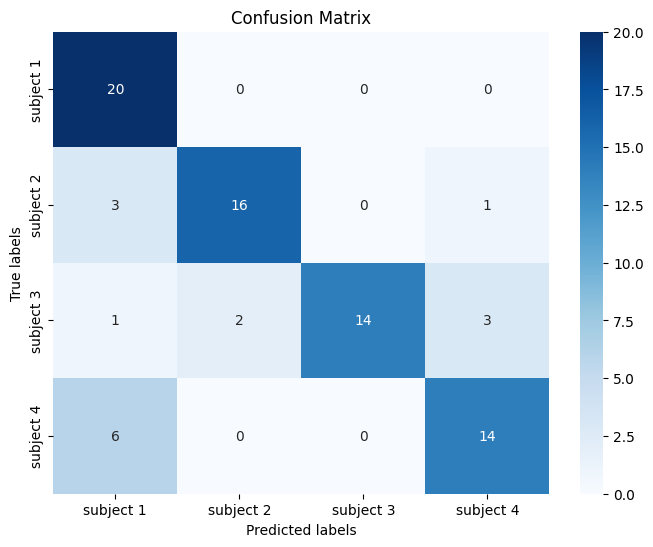

Accuracy: 0.8
Precision: 0.8333333333333333
Recall: 0.8
F1 Score: 0.8006191950464396


In [61]:
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['subject 1', 'subject 2', 'subject 3', 'subject 4'], yticklabels=['subject 1', 'subject 2', 'subject 3', 'subject 4'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


In [62]:
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

predictions = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Random Forest Accuracy:", f"{accuracy * 100} %")

Random Forest Accuracy: 93.75 %


In [ ]:
pickle_file = "rf_wavelet.pkl"
with open(pickle_file, 'wb') as file:
    pickle.dump(rf_classifier, file)

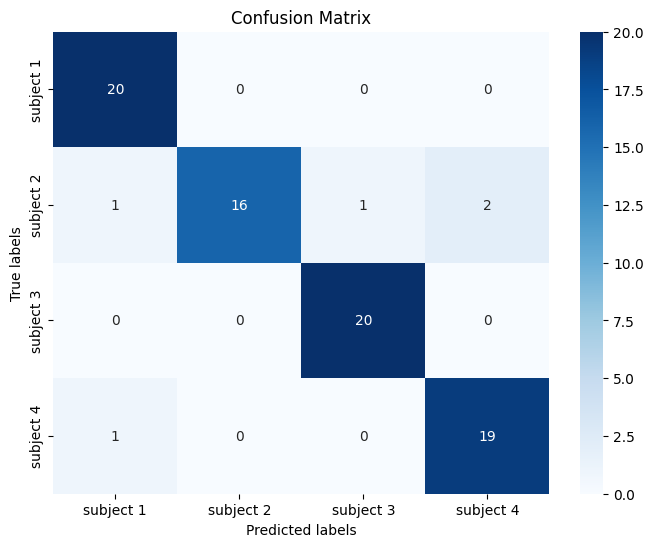

Accuracy: 0.9375
Precision: 0.9415584415584416
Recall: 0.9375
F1 Score: 0.9359272164150213


In [63]:
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=['subject 1', 'subject 2', 'subject 3', 'subject 4'], yticklabels=['subject 1', 'subject 2', 'subject 3', 'subject 4'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
